In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
import re

## Load Data

In [2]:
def load_data(data_path="../data/"):
    """Load the credit scoring dataset."""
    # Check if the data directory exists
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Data directory '{data_path}' not found.")
    
    # Look for CSV files in the data directory
    csv_files = [f for f in os.listdir(data_path) if f.endswith('train.csv')]
    
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in '{data_path}'.")
    
    # Load the first CSV file found
    file_path = os.path.join(data_path, csv_files[0])
    print(f"Loading data from: {file_path}")
    
    return pd.read_csv(file_path)


In [3]:
df = load_data()

Loading data from: ../data/train.csv


/tmp/ipykernel_15323/948120084.py:17: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


## Overview

In [4]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [6]:
print(f"Number of rows : {len(df)}")

Number of rows : 100000


In [7]:
total_memory = df.memory_usage(deep=True).sum() / (1024**2)
print(f"Total data memory usage: {total_memory:.2f} MB")

Total data memory usage: 120.56 MB


In [8]:
print(f"List all column names :\n\n {df.columns}")

List all column names :

 Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')


In [9]:
print(f"Number of columns :‌ {len(df.columns)}")

Number of columns :‌ 28


## Missing Data

In [10]:
def report_missing_data(df, dataset_name="Dataset"):
    """
    Reports missing data in a dataset with details and visualizations.
    
    Parameters:
    - df: pandas DataFrame - The dataset to analyze
    - dataset_name: str - Name of the dataset for reporting (default: "Dataset")
    
    Returns:
    - None: Prints results and displays visualizations
    """
    
    # Calculate total number of entries
    total_entries = df.size  # Total number of cells (rows * columns)
    total_rows = df.shape[0]
    total_cols = df.shape[1]
    
    # Identify variables with missing data
    missing_by_column = df.isnull().sum()  # Count of missing values per column
    missing_percent_by_column = (missing_by_column / total_rows) * 100  # Percentage per column
    
    # Filter to columns with missing data
    missing_columns = missing_by_column[missing_by_column > 0]
    missing_percent_columns = missing_percent_by_column[missing_by_column > 0]
    
    # Calculate total missing data
    total_missing = missing_by_column.sum()  # Total count of missing values
    total_missing_percent = (total_missing / total_entries) * 100  # Total percentage
    
    # Print report
    print(f"### Missing Data Report for {dataset_name} ###")
    print(f"Total Rows: {total_rows}, Total Columns: {total_cols}")
    print(f"Total Entries (cells): {total_entries}")
    print("\n#### Variables with Missing Data ####")
    if len(missing_columns) > 0:
        for col, count in missing_columns.items():
            percent = missing_percent_by_column[col]
            print(f"{col}: {count} missing values ({percent:.2f}%)")
    else:
        print("No missing data found in any variable.")
    
    print(f"\n#### Overall Missing Data ####")
    print(f"Total Missing Values: {total_missing}")
    print(f"Total Missing Percentage: {total_missing_percent:.2f}%")
    

    # Visualizations
    plt.figure(figsize=(12, 8))
    
    # Heatmap of missing data
    plt.subplot(2, 1, 1)
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
    plt.title(f"Missing Data Heatmap - {dataset_name}")
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    
    # Bar plot of missing data by column
    plt.subplot(2, 1, 2)
    missing_percent_columns.plot(kind='bar', color='skyblue')
    plt.title(f"Percentage of Missing Data by Variable - {dataset_name}")
    plt.xlabel("Variables")
    plt.ylabel("Percentage Missing (%)")
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

### Missing Data Report for Dataset ###
Total Rows: 100000, Total Columns: 28
Total Entries (cells): 2800000

#### Variables with Missing Data ####
Name: 9985 missing values (9.98%)
Monthly_Inhand_Salary: 15002 missing values (15.00%)
Type_of_Loan: 11408 missing values (11.41%)
Num_of_Delayed_Payment: 7002 missing values (7.00%)
Num_Credit_Inquiries: 1965 missing values (1.97%)
Credit_History_Age: 9030 missing values (9.03%)
Amount_invested_monthly: 4479 missing values (4.48%)
Monthly_Balance: 1200 missing values (1.20%)

#### Overall Missing Data ####
Total Missing Values: 60071
Total Missing Percentage: 2.15%


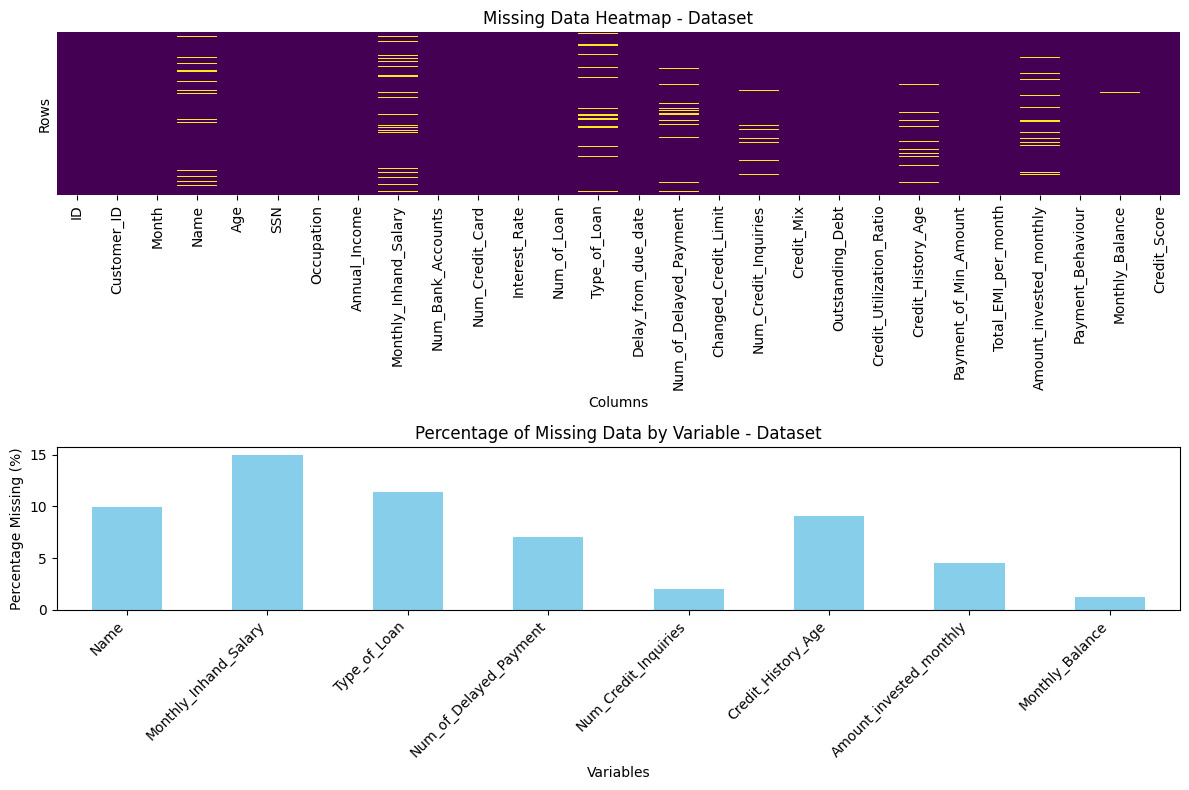

In [11]:
report_missing_data(df)

## Data Structure & Types

#### Data Types 
- Check data types of each column

In [12]:
df.dtypes

ID                           object
Customer_ID                  object
Month                        object
Name                         object
Age                          object
SSN                          object
Occupation                   object
Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour            object
Monthly_Balance              object
Credit_Score                

#### Categorical vs. Numerical

In [13]:
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
print("Categorical Columns:", categorical_columns)
print("Numerical Columns:", numerical_columns)

Categorical Columns: Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Num_of_Loan', 'Type_of_Loan',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Credit_Mix',
       'Outstanding_Debt', 'Credit_History_Age', 'Payment_of_Min_Amount',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')
Numerical Columns: Index(['Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Delay_from_due_date', 'Num_Credit_Inquiries',
       'Credit_Utilization_Ratio', 'Total_EMI_per_month'],
      dtype='object')


In [14]:
discrete_vars = [col for col in numerical_columns if df[col].nunique() < 100 and df[col].dtype == 'int64']
continuous_vars = [col for col in numerical_columns if df[col].dtype == 'float64' or df[col].nunique() >= 100]
print("Discrete Variables:", discrete_vars)
print("Continuous Variables:", continuous_vars)

Discrete Variables: ['Delay_from_due_date']
Continuous Variables: ['Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_Credit_Inquiries', 'Credit_Utilization_Ratio', 'Total_EMI_per_month']


In [15]:
# summary statistics for numerical
df.describe()

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,4194.170850,17.091280,22.47443,72.466040,21.068780,27.754251,32.285173,1403.118217
std,3183.686167,117.404834,129.05741,466.422621,14.860104,193.177339,5.116875,8306.041270
min,303.645417,-1.000000,0.00000,1.000000,-5.000000,0.000000,20.000000,0.000000
25%,1625.568229,3.000000,4.00000,8.000000,10.000000,3.000000,28.052567,30.306660
50%,3093.745000,6.000000,5.00000,13.000000,18.000000,6.000000,32.305784,69.249473
75%,5957.448333,7.000000,7.00000,20.000000,28.000000,9.000000,36.496663,161.224249
max,15204.633333,1798.000000,1499.00000,5797.000000,67.000000,2597.000000,50.000000,82331.000000


In [16]:
def categorical_summary_stats(df, categorical_columns=None):
    """
    Generate summary statistics for categorical variables in a dataframe.
    
    Parameters:
    df (pandas.DataFrame): The dataframe to analyze
    categorical_columns (list, optional): List of categorical column names to analyze.
                                         If None, will try to identify categorical columns.
    
    Returns:
    dict: Dictionary where keys are column names and values are dictionaries of summary statistics
    """    
    # If no categorical columns specified, try to identify them
    if categorical_columns is None:
        # Select object, category, and boolean dtypes
        categorical_columns = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
        
        # Also include numeric columns with low cardinality (fewer than 10 unique values)
        for col in df.select_dtypes(include=['number']).columns:
            if df[col].nunique() < 10:
                categorical_columns.append(col)
    
    summary = {}
    
    for col in categorical_columns:
        if col not in df.columns:
            continue
            
        # Basic stats
        value_counts = df[col].value_counts()
        unique_values = df[col].unique()
        missing_values = df[col].isna().sum()
        
        # Get mode (most frequent value)
        mode_value = df[col].mode()[0] if not df[col].empty else None
        mode_count = value_counts.iloc[0] if not value_counts.empty else 0
        mode_percentage = (mode_count / len(df)) * 100 if len(df) > 0 else 0
        
        # Get top 5 categories with counts and percentages
        top_categories = []
        for value, count in value_counts.head(5).items():
            percentage = (count / len(df)) * 100
            top_categories.append({
                'value': value,
                'count': count,
                'percentage': round(percentage, 2)
            })
        
        # Compile column summary
        summary[col] = {
            'unique_values': len(unique_values),
            'missing_values': missing_values,
            'missing_percentage': round((missing_values / len(df)) * 100, 2) if len(df) > 0 else 0,
            'mode': {
                'value': mode_value,
                'count': mode_count,
                'percentage': round(mode_percentage, 2)
            },
            'top_categories': top_categories,
            'all_categories': [str(v) for v in unique_values]
        }
    
    return summary

In [28]:
def categorical_summary_stats_result(col_name):
    cat_stats = categorical_summary_stats(df)
    stats = cat_stats[col_name]
    print(f"Summary for {col_name}:")
    print(f"- Unique values: {stats['unique_values']}")
    print(f"- Most common value: {stats['mode']['value']} (occurs {stats['mode']['percentage']}% of the time)")
    print(f"- Top categories:")
    for cat in stats['top_categories']:
        print(f"  • {cat['value']}: {cat['count']} ({cat['percentage']}%)")
    # print(f"\n {stats['all_categories']}")

In [29]:
categorical_columns = [
    "Occupation", 
    "Type_of_Loan", 
    "Credit_Mix", 
    "Payment_of_Min_Amount", 
    "Payment_Behaviour", 
    "Credit_Score"
]

for col in categorical_columns:
    categorical_summary_stats_result(col)
    print("\n")


Summary for Occupation:
- Unique values: 16
- Most common value: _______ (occurs 7.06% of the time)
- Top categories:
  • _______: 7062 (7.06%)
  • Lawyer: 6575 (6.58%)
  • Architect: 6355 (6.35%)
  • Engineer: 6350 (6.35%)
  • Scientist: 6299 (6.3%)


Summary for Type_of_Loan:
- Unique values: 6261
- Most common value: Not Specified (occurs 1.41% of the time)
- Top categories:
  • Not Specified: 1408 (1.41%)
  • Credit-Builder Loan: 1280 (1.28%)
  • Personal Loan: 1272 (1.27%)
  • Debt Consolidation Loan: 1264 (1.26%)
  • Student Loan: 1240 (1.24%)


Summary for Credit_Mix:
- Unique values: 4
- Most common value: Standard (occurs 36.48% of the time)
- Top categories:
  • Standard: 36479 (36.48%)
  • Good: 24337 (24.34%)
  • _: 20195 (20.2%)
  • Bad: 18989 (18.99%)


Summary for Payment_of_Min_Amount:
- Unique values: 3
- Most common value: Yes (occurs 52.33% of the time)
- Top categories:
  • Yes: 52326 (52.33%)
  • No: 35667 (35.67%)
  • NM: 12007 (12.01%)


Summary for Payment_Behav

#### Mixed Data Types

In [25]:
for col in df.columns:
    unique_types = set(df[col].apply(type))
    if len(unique_types) > 1:
        print(f"Column '{col}' has mixed types: {unique_types}")

Column 'Name' has mixed types: {<class 'str'>, <class 'float'>}
Column 'Type_of_Loan' has mixed types: {<class 'str'>, <class 'float'>}
Column 'Num_of_Delayed_Payment' has mixed types: {<class 'str'>, <class 'float'>}
Column 'Credit_History_Age' has mixed types: {<class 'str'>, <class 'float'>}
Column 'Amount_invested_monthly' has mixed types: {<class 'str'>, <class 'float'>}
Column 'Monthly_Balance' has mixed types: {<class 'str'>, <class 'float'>}
